# Load libraries needed

In [1979]:
#Pandas
import pandas as pd
from pandas import ExcelWriter, ExcelFile

#Numpy
import numpy as np

#NLTK
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
stop = stopwords.words('english')

#SkLearn
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif

#Other
import string
import warnings
#Tons of pink warnings about "version changes" just ignoring them
warnings.filterwarnings("ignore")

#Word Cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel('txpl_project.xlsx')

# Cute Word Cloud

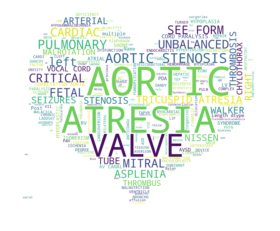

In [1980]:
data = df.dropna(subset=['CHD_OTHSP','SPECOTH','SURGERY_HISTORY'])

# Start with one review:
text = str(data.CHD_OTHSP) + str(data.SPECOTH) + str(data.SPECOTH)
heart_mask = np.array(Image.open("heart2.jpg"))
                    
wordcloud = WordCloud(mask=heart_mask,background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear",)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [1981]:
#Check to make sure we have the columns and it imported 
print(df.columns)

#The categorical variables needed to one hot encode
cat_var = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']] 

#Do not want to hot encode these.  
cat_var.remove('CHD_OTHSP')
cat_var.remove('SPECOTH')
cat_var.remove('SURGERY_HISTORY')

#show the categorical
print(cat_var)

Index(['AGE_LISTING', 'AGE_TXPL', 'STATLIST', 'SLVAD', 'SLECMO', 'SLVENT',
       'HXARRYTH', 'HXCPR', 'HXDIAB', 'HXGI',
       ...
       'TXHDL_R', 'TXVLDL_R', 'eGFR_TXPL', 'GRAFT_LOSS', 'INT_GRAFT_LOSS',
       'SURGERY_HISTORY', 'SV_GROUP', 'LSNYHA_T', 'LSRHFCL_T', 'PATIENT_ID'],
      dtype='object', length=197)
['STATLIST', 'SLINODS', 'SEX', 'TXSTAT', 'DONORSEX', 'STATUS_LISTING', 'STATUS_TXPL', 'LSNYHA_T', 'LSRHFCL_T']


# Prepare Data 

In [1982]:
#This unnamed column gets added as an index from importing with pandas, not sure how to drop it in the 
#import so just dropping it here
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

#Looking at the data specs
print(df.shape)
print(df.head())
print(df.describe())

(6871, 197)
   AGE_LISTING  AGE_TXPL STATLIST  SLVAD  SLECMO  SLVENT  HXARRYTH  HXCPR  \
0       15.855    16.047        1  0.000   0.000   0.000     1.000    nan   
1        5.065     5.101        1  0.000   0.000   0.000     0.000    nan   
2        9.090     9.279        2  0.000   0.000   0.000     0.000    nan   
3        0.723     1.136        2  0.000   0.000   0.000     0.000    nan   
4        3.981     4.115        2  0.000   0.000   0.000     0.000    nan   

   HXDIAB  HXGI  ...  TXHDL_R  TXVLDL_R  eGFR_TXPL  GRAFT_LOSS  \
0   0.000 0.000  ...      nan       nan     81.050           1   
1   0.000 0.000  ...      nan       nan    123.889           0   
2   0.000 0.000  ...      nan       nan    135.245           1   
3   0.000 0.000  ...      nan       nan     71.255           1   
4   0.000 1.000  ...      nan       nan     61.263           1   

   INT_GRAFT_LOSS                        SURGERY_HISTORY  SV_GROUP  \
0           2.965  Physician Reported No Other Surgeries  

In [1983]:
#One hot encode everything
df_processed = pd.get_dummies(df, prefix_sep="_",columns=cat_var)

#Text variables to drop from the first model
text = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] in ['object']] 

#These are the text variables now because we transformed the others
print(text)

#Storing all continuous variables
con_var = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] not in ['object']] 

#We don't want this in any of the models, it's useless information
con_var.remove('PATIENT_ID')

#Look at how many people are flagged as Heterotaxy to ensure it was the amount Tobias thought
print(df_processed['GRAFT_LOSS'].value_counts())

#Set to only heterotaxy
df_filtered_list = df_processed[df_processed['SV_GROUP'] == 1]

#I'm just filtering above to see different numbers for testing
print(df_processed.shape)
print(df_filtered_list.shape)

['SPECOTH', 'CHD_OTHSP', 'SURGERY_HISTORY']
0    5206
1    1665
Name: GRAFT_LOSS, dtype: int64
(6871, 222)
(1702, 222)


In [1984]:
#Model without text fields
#Drop the text fields
df_model1 = df_filtered_list.drop(text,axis=1)

In [1985]:
df_model1

#Look at missing
def missing(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))

# #This is an issue
# missing(df_model1)

#Eliminate missing data that is more than 20%
filter_missing = df_model1[df_model1.columns[df_model1.isnull().mean() < 0.25]]

missing(filter_missing)




TXICU                                                                                                                                    23.680
HXMED                                                                                                                                    20.800
LCREAT_R                                                                                                                                 18.210
CHD_HRH                                                                                                                                  13.450
CHD_TAPVR                                                                                                                                13.450
CHD_LVOTOAS                                                                                                                              13.450
CHD_DILV                                                                                                                                

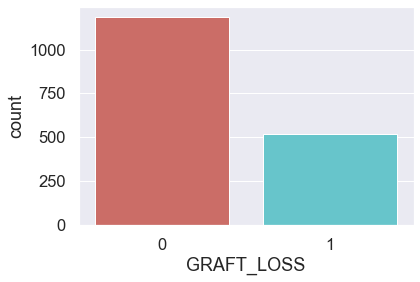

In [1986]:
#Impute with the median
df_imp = filter_missing.fillna(filter_missing.median())

df_imp

sns.set(font_scale=1.5)
countplt=sns.countplot(x='GRAFT_LOSS', data=df_imp, palette ='hls')
plt.show()


# Prepare Data with Test Train Split

In [1987]:
covariate_list = ['AGE_LISTING','AGE_TXPL','SEX_F','STATUS_TXPL_Priority','RRACE_B','LCREAT_R','TXCREAT_R','BSA_DONOR','DONORSEX_F','SLECMO','TXIVINO','BSA_TXPL','SLINODS_High Dose or Multiple IV','TXSTAT_1A','DONISCH']

#select a few
cols = [col for col in df_imp.columns if col in covariate_list]
                 
#Every column incase teting
cols_all = [col for col in df_imp.columns if col not in ['GRAFT_LOSS','PATIENT_ID','INT_GRAFT_LOSS','SV_GROUP','CHD_HLH','CHD_TRIAT','CHD_DILV']]

data = df_imp[cols]

#I ran a model just to see the scores for all covariates - it was roughly the same which surprised me
data_all = df_imp[cols_all]

print("Percent Missing for Features Included in Model")
print(missing(filter_missing[covariate_list]))
#The predictor
target = df_imp['GRAFT_LOSS']

#Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data,target, test_size = 0.3)

#Print dimensions
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)



Percent Missing for Features Included in Model
LCREAT_R                           18.210
BSA_DONOR                           4.170
BSA_TXPL                            2.940
DONISCH                             2.530
TXCREAT_R                           1.230
SLECMO                              0.590
TXIVINO                             0.410
TXSTAT_1A                           0.000
SLINODS_High Dose or Multiple IV    0.000
DONORSEX_F                          0.000
RRACE_B                             0.000
STATUS_TXPL_Priority                0.000
SEX_F                               0.000
AGE_TXPL                            0.000
AGE_LISTING                         0.000
dtype: float64
None
(1191, 15)
(511, 15)
(1191,)
(511,)


In [1918]:
#Altering this to display mutual information because there are negative values in age so chisq cannot be d
class SelectKBestCustom(SelectKBest):

    # Changed here
    def fit(self, X, y, discrete_features='auto'):
        X, y = check_X_y(X, y, ['csr', 'csc'], multi_output=True)

        if not callable(self.score_func):
            raise TypeError("The score function should be a callable, %s (%s) "
                        "was passed."
                        % (self.score_func, type(self.score_func)))

        self._check_params(X, y)

        # Changed here also
        score_func_ret = self.score_func(X, y, discrete_features)
        if isinstance(score_func_ret, (list, tuple)):
            self.scores_, self.pvalues_ = score_func_ret
            self.pvalues_ = np.asarray(self.pvalues_)
        else:
            self.scores_ = score_func_ret
            self.pvalues_ = None

        self.scores_ = np.asarray(self.scores_)
        return self



bestfeatures = SelectKBest(mutual_info_classif, k=10)
fit = bestfeatures.fit(data_all,target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_all.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features



                                                 Specs  Score
96                  LSRHFCL_T_Assessment not Completed  0.040
101                       LSRHFCL_T_Not Done: Too Sick  0.036
75                    SLINODS_High Dose or Multiple IV  0.026
27                                             CHD_VSD  0.023
63                                        WEIGHT_DONOR  0.021
87                                STATUS_TXPL_Priority  0.021
65                                            LCREAT_R  0.021
84                                          DONORSEX_M  0.019
67                                             TXBUN_R  0.017
89                   LSNYHA_T_Assessment not Completed  0.017
88                                 STATUS_TXPL_Routine  0.017
49                                               TXICU  0.016
98   LSRHFCL_T_Class II: Mild tachypnea and/or diap...  0.016
32                                         CHD_LVOTOAS  0.015
64                                           BSA_DONOR  0.014


# Decision Tree

In [2007]:
dt = DecisionTreeClassifier()

def modelPrediction(model,data_train,target_train,target_test,data_test,model_name,data_all,target_all):
    pred = model.fit(data_train, target_train).predict(data_test)
    Accuracy = accuracy_score(target_test, pred)
    f1 = f1_score(target_test, pred, average='weighted')
    precision = precision_score(target_test, pred, average="weighted")
    recall = recall_score(target_test, pred, average="weighted")   
    AUC = roc_auc_score(target_test, pred, average='weighted')
    tn, fp, fn, tp = confusion_matrix(target_test, pred).ravel()
    pd.options.display.float_format = '{:,.3f}'.format
    results = pd.DataFrame(
    {
    'Model Name': [model_name],
    'Accuracy': [Accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC': [AUC],
    'True Negative': [tn],
    'False Positive': [fp],
    'False Negative': [fn],
    'True Positive': [tp],
    })
    return results.stack()

print(modelPrediction(dt,X_train,Y_train,Y_test,X_test,"Decision Tree",data,target))


0  Model Name        Decision Tree
   Accuracy                  0.597
   Precision                 0.612
   Recall                    0.597
   F1 Score                  0.604
   AUC                       0.532
   True Negative               249
   False Positive              113
   False Negative               93
   True Positive                56
dtype: object


# XG Boost

In [1991]:
xg = XGBClassifier()

print(modelPrediction(xg,X_train,Y_train,Y_test,X_test,"XG Boost",data,target))

0  Model Name        XG Boost
   Accuracy             0.705
   Precision            0.654
   Recall               0.705
   F1 Score             0.645
   AUC                  0.541
   True Negative          338
   False Positive          24
   False Negative         127
   True Positive           22
dtype: object


# SVC 

In [1992]:
svc_model = SVC(kernel='linear')

print(modelPrediction(svc_model,X_train,Y_train,Y_test,X_test,"SVM",data,target))


0  Model Name         SVM
   Accuracy         0.708
   Precision        0.502
   Recall           0.708
   F1 Score         0.588
   AUC              0.500
   True Negative      362
   False Positive       0
   False Negative     149
   True Positive        0
dtype: object


# Logistic Regression

In [1993]:
logit = LogisticRegression()

print(modelPrediction(logit,X_train,Y_train,Y_test,X_test,"Logisitc Regression",data,target))

0  Model Name        Logisitc Regression
   Accuracy                        0.706
   Precision                       0.652
   Recall                          0.706
   F1 Score                        0.631
   AUC                             0.528
   True Negative                     346
   False Positive                     16
   False Negative                    134
   True Positive                      15
dtype: object


# Adding first text field - SURGERY HISTORY USING TF-IDF

In [2008]:
df_model2 = df_filtered_list.drop(['SPECOTH', 'CHD_OTHSP'], axis = 1) 

#New covariate list with first text field added
covariate_list_txt = ['AGE_LISTING','AGE_TXPL','SEX_F','STATUS_TXPL_Priority','RRACE_B','LCREAT_R','TXCREAT_R','BSA_DONOR','DONORSEX_F','SLECMO','TXIVINO','BSA_TXPL','LSRHFCL_T_Not Done: Too Sick','TXSTAT_1A','DONISCH','SURGERY_HISTORY','GRAFT_LOSS']

#Add these columns
cols2 = [col for col in df_model2.columns if col in covariate_list_txt]

#Every column incase teting
cols_temp2 = [col for col in df_model2.columns if col not in ['PATIENT_ID','INT_GRAFT_LOSS','SV_GROUP','CHD_HLH','CHD_TRIAT','CHD_DILV']]

#All but predictor
df_model2 = df_model2[cols2]

#Remove punctuation
df_model2["SURG_NO_PUNC"] = df_model2['SURGERY_HISTORY'].str.replace('[^\w\s]','')

#Drop CHD_OTHSP because I created CHD_NO_PUNC
df_model_drop = df_model2.drop('SURGERY_HISTORY',axis=1)

#Changed all blanks to missing
df_model_drop['SURG_NO_PUNC'].fillna('', inplace=True)

tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english',tokenizer=word_tokenize)
score = tfidf.fit_transform(df_model_drop['SURG_NO_PUNC'])

df = pd.DataFrame(score.toarray(), columns=tfidf.get_feature_names())

df_model_drop = df_model_drop.drop('SURG_NO_PUNC',axis=1)

df_fin = pd.concat([df_model_drop.reset_index(drop=True),df.reset_index(drop=True)], axis=1)

print(df_fin['GRAFT_LOSS'].value_counts())

df_fin

0    1184
1     518
Name: GRAFT_LOSS, dtype: int64


,AGE_LISTING,AGE_TXPL,SLECMO,RRACE_B,TXIVINO,DONISCH,BSA_TXPL,BSA_DONOR,LCREAT_R,TXCREAT_R,...,unicuspid,v,valve,valvotomy,valvuloplasty,vein,veins,vessels,vsd,wautologous
0,0.723,1.136,0.000,0.000,0.000,285.000,0.436,0.366,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,4.893,5.098,0.000,0.000,0.000,262.000,0.646,0.664,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.008,0.041,0.000,0.000,1.000,355.000,0.243,0.261,0.900,0.800,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2.533,2.538,1.000,0.000,1.000,185.000,0.496,0.519,0.300,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.068,0.134,0.000,0.000,0.000,332.000,0.245,0.205,0.300,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.011,0.192,0.000,0.000,1.000,202.000,0.251,0.477,0.700,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.008,0.129,0.000,0.000,1.000,238.000,0.280,0.415,0.700,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.014,0.257,0.000,0.000,0.000,240.000,0.247,0.451,1.000,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.014,0.099,0.000,0.000,0.000,307.000,0.258,0.272,0.800,0.800,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,4.860,4.890,0.000,0.000,0.000,383.000,0.576,0.594,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [2009]:
#Impute with the median
df_imp2 = df_fin.fillna(df_fin.median())

#Select all but predictor
first_text = [col for col in df_imp2.columns if col not in ['GRAFT_LOSS']]

#If we only want to look at JUST the text, no continuous features
only_text = [col for col in df_imp2.columns if col not in covariate_list_txt]

#The data with all columns but target
data_2 = df_imp2[first_text]

#The data with all columns but target
data_2_ot = df_imp2[only_text]

#The predictor
target_2 = df_imp2['GRAFT_LOSS']

#Split the data
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(data_2,target_2, test_size = 0.3)

#Print dimensions
print(X_train_2.shape)
print(X_test_2.shape)
print(Y_train_2.shape)
print(Y_test_2.shape)

print(X_train_2.columns.values.tolist())

(1191, 191)
(511, 191)
(1191,)
(511,)
['AGE_LISTING', 'AGE_TXPL', 'SLECMO', 'RRACE_B', 'TXIVINO', 'DONISCH', 'BSA_TXPL', 'BSA_DONOR', 'LCREAT_R', 'TXCREAT_R', 'SEX_F', 'TXSTAT_1A', 'DONORSEX_F', 'STATUS_TXPL_Priority', 'LSRHFCL_T_Not Done: Too Sick', '1', '17', '17pda', '18', '2', '54', 'aa', 'angioplasty', 'annuloplasty', 'anomaly', 'ao', 'aortic', 'ap', 'application', 'arc', 'arch', 'arterial', 'arteries', 'arterioplasty', 'artery', 'asd', 'atrial', 'attempted', 'av', 'balloon', 'band', 'banding', 'bands', 'bcps', 'bidirectional', 'bilat', 'bilateral', 'biopsy', 'bivad', 'blalockhanlon', 'bt', 'bts', 'btshunt', 'cabg', 'cannulation', 'cath', 'catheter', 'central', 'closure', 'coarc', 'coarct', 'coarctation', 'coarctaton', 'coartation', 'complete', 'conduit', 'coronary', 'damus', 'debanding', 'defect', 'dilation', 'division', 'dks', 'drainage', 'dtransposition', 'ebsteins', 'ecmo', 'enlargement', 'fenestration', 'fluid', 'fontan', 'foramen', 'form', 'g', 'glenn', 'great', 'heart', 'he

# Continuous Features + Surgery History Text

In [2010]:
print(modelPrediction(logit,X_train_2,Y_train_2,Y_test_2,X_test_2,"Logistic Regression",data_2,target_2))
print(modelPrediction(svc_model,X_train_2,Y_train_2,Y_test_2,X_test_2,"SVM",data_2,target_2))
print(modelPrediction(dt,X_train_2,Y_train_2,Y_test_2,X_test_2,"Decision Tree",data_2,target_2))
print(modelPrediction(xg,X_train_2,Y_train_2,Y_test_2,X_test_2,"XG Boost",data_2,target_2))

0  Model Name        Logistic Regression
   Accuracy                        0.744
   Precision                       0.711
   Recall                          0.744
   F1 Score                        0.701
   AUC                             0.580
   True Negative                     349
   False Positive                     24
   False Negative                    107
   True Positive                      31
dtype: object
0  Model Name         SVM
   Accuracy         0.726
   Precision        0.600
   Recall           0.726
   F1 Score         0.618
   AUC              0.500
   True Negative      370
   False Positive       3
   False Negative     137
   True Positive        1
dtype: object
0  Model Name        Decision Tree
   Accuracy                  0.630
   Precision                 0.657
   Recall                    0.630
   F1 Score                  0.641
   AUC                       0.569
   True Negative               262
   False Positive              111
   False Negative     

# Just Surgery History Text

In [1998]:
#Split the data
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(data_2_ot,target_2, test_size = 0.3)

#Print dimensions
print(X_train_2.shape)
print(X_test_2.shape)
print(Y_train_2.shape)
print(Y_test_2.shape)

print(X_train_2.columns.values.tolist())

print(modelPrediction(logit,X_train_2,Y_train_2,Y_test_2,X_test_2,"Logistic Regression",data_2,target_2))
print(modelPrediction(svc_model,X_train_2,Y_train_2,Y_test_2,X_test_2,"SVM",data_2,target_2))
print(modelPrediction(dt,X_train_2,Y_train_2,Y_test_2,X_test_2,"Decision Tree",data_2,target_2))
print(modelPrediction(xg,X_train_2,Y_train_2,Y_test_2,X_test_2,"XG Boost",data_2,target_2))

(1191, 176)
(511, 176)
(1191,)
(511,)
['1', '17', '17pda', '18', '2', '54', 'aa', 'angioplasty', 'annuloplasty', 'anomaly', 'ao', 'aortic', 'ap', 'application', 'arc', 'arch', 'arterial', 'arteries', 'arterioplasty', 'artery', 'asd', 'atrial', 'attempted', 'av', 'balloon', 'band', 'banding', 'bands', 'bcps', 'bidirectional', 'bilat', 'bilateral', 'biopsy', 'bivad', 'blalockhanlon', 'bt', 'bts', 'btshunt', 'cabg', 'cannulation', 'cath', 'catheter', 'central', 'closure', 'coarc', 'coarct', 'coarctation', 'coarctaton', 'coartation', 'complete', 'conduit', 'coronary', 'damus', 'debanding', 'defect', 'dilation', 'division', 'dks', 'drainage', 'dtransposition', 'ebsteins', 'ecmo', 'enlargement', 'fenestration', 'fluid', 'fontan', 'foramen', 'form', 'g', 'glenn', 'great', 'heart', 'hemi', 'hemifontan', 'homograft', 'hybraid', 'hybrid', 'hypoplastic', 'ii', 'intubation', 'kaye', 'krono', 'lab', 'left', 'ligation', 'lpt', 'lung', 'mbts', 'mitral', 'modification', 'modified', 'muscle', 'muscular

# ADD CHD_OTHSP

In [1999]:
#New covariate list with first text field added
covariate_list_txt = ['CHD_OTHSP']

#Add these columns
cols2 = [col for col in df_filtered_list.columns if col in covariate_list_txt]

df_model3 = df_filtered_list[cols2]

df_model3

#Remove punctuation
df_model3["CHD_NO_PUNC"] = df_model3['CHD_OTHSP'].str.replace('[^\w\s]','')

#Drop CHD_OTHSP because I created CHD_NO_PUNC
df_model_drop2 = df_model3.drop('CHD_OTHSP',axis=1)

#Changed all blanks to missing
df_model_drop2['CHD_NO_PUNC'].fillna('', inplace=True)

tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english',tokenizer=word_tokenize)
score = tfidf.fit_transform(df_model_drop2['CHD_NO_PUNC'])

# New data frame containing the tfidf features and their scores
df2 = pd.DataFrame(score.toarray(), columns=tfidf.get_feature_names())

df_fin2 = pd.concat([df_imp2.reset_index(drop=True),df2.reset_index(drop=True)], axis=1)

#Look at how many people are flagged as Heterotaxy to ensure it was the amount Tobias thought
print(df_fin2['GRAFT_LOSS'].value_counts())

df_fin2

0    1184
1     518
Name: GRAFT_LOSS, dtype: int64


,AGE_LISTING,AGE_TXPL,SLECMO,RRACE_B,TXIVINO,DONISCH,BSA_TXPL,BSA_DONOR,LCREAT_R,TXCREAT_R,...,unbalanced,va,valvar,valve,valvehypoplasti,vena,venous,ventricle,vsd,wventricular
0,0.723,1.136,0.000,0.000,0.000,285.000,0.436,0.366,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,4.893,5.098,0.000,0.000,0.000,262.000,0.646,0.664,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.008,0.041,0.000,0.000,1.000,355.000,0.243,0.261,0.900,0.800,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2.533,2.538,1.000,0.000,1.000,185.000,0.496,0.519,0.300,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.068,0.134,0.000,0.000,0.000,332.000,0.245,0.205,0.300,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.011,0.192,0.000,0.000,1.000,202.000,0.251,0.477,0.700,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.008,0.129,0.000,0.000,1.000,238.000,0.280,0.415,0.700,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.014,0.257,0.000,0.000,0.000,240.000,0.247,0.451,1.000,0.300,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.014,0.099,0.000,0.000,0.000,307.000,0.258,0.272,0.800,0.800,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,4.860,4.890,0.000,0.000,0.000,383.000,0.576,0.594,0.400,0.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [2000]:
df_imp3 = df_fin2

df_imp3 = df_imp3.loc[:,~df_imp3.columns.duplicated()]

first_text = [col for col in df_imp3.columns if col not in ['GRAFT_LOSS']]
only_text = [col for col in df_imp3.columns if col not in ['AGE_LISTING', 'AGE_TXPL', 'SLECMO', 'HXMED', 'RRACE_B', 'TXIVINO', 'DONISCH', 'BSA_TXPL', 'BSA_DONOR', 'LCREAT_R', 'TXCREAT_R', 'GRAFT_LOSS', 'SEX_F', 'TXSTAT_1A', 'DONORSEX_F', 'STATUS_TXPL_Priority','LSRHFCL_T_Not Done: Too Sick']]

#The data with all columns but target
data_3 = df_imp3[first_text]

#The predictor
target_3 = df_imp3['GRAFT_LOSS']

#Split the data
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(data_3,target_3, test_size = 0.3)

#Print dimensions
print(X_train_3.shape)
print(X_test_3.shape)
print(Y_train_3.shape)
print(Y_test_3.shape)

print(X_train_3.columns.values.tolist())


(1191, 295)
(511, 295)
(1191,)
(511,)
['AGE_LISTING', 'AGE_TXPL', 'SLECMO', 'RRACE_B', 'TXIVINO', 'DONISCH', 'BSA_TXPL', 'BSA_DONOR', 'LCREAT_R', 'TXCREAT_R', 'SEX_F', 'TXSTAT_1A', 'DONORSEX_F', 'STATUS_TXPL_Priority', 'LSRHFCL_T_Not Done: Too Sick', '1', '17', '17pda', '18', '2', '54', 'aa', 'angioplasty', 'annuloplasty', 'anomaly', 'ao', 'aortic', 'ap', 'application', 'arc', 'arch', 'arterial', 'arteries', 'arterioplasty', 'artery', 'asd', 'atrial', 'attempted', 'av', 'balloon', 'band', 'banding', 'bands', 'bcps', 'bidirectional', 'bilat', 'bilateral', 'biopsy', 'bivad', 'blalockhanlon', 'bt', 'bts', 'btshunt', 'cabg', 'cannulation', 'cath', 'catheter', 'central', 'closure', 'coarc', 'coarct', 'coarctation', 'coarctaton', 'coartation', 'complete', 'conduit', 'coronary', 'damus', 'debanding', 'defect', 'dilation', 'division', 'dks', 'drainage', 'dtransposition', 'ebsteins', 'ecmo', 'enlargement', 'fenestration', 'fluid', 'fontan', 'foramen', 'form', 'g', 'glenn', 'great', 'heart', 'he

In [2001]:
print(modelPrediction(logit,X_train_3,Y_train_3,Y_test_3,X_test_3,"Logistic Regression",data_3,target_3))

print(modelPrediction(dt,X_train_3,Y_train_3,Y_test_3,X_test_3,"Decision Tree",data_3,target_3))

print(modelPrediction(svc_model,X_train_3,Y_train_3,Y_test_3,X_test_3,"SVM",data_3,target_3))

print(modelPrediction(xg,X_train_3,Y_train_3,Y_test_3,X_test_3,"XG Boost",data_3,target_3))

0  Model Name        Logistic Regression
   Accuracy                        0.710
   Precision                       0.661
   Recall                          0.710
   F1 Score                        0.644
   AUC                             0.538
   True Negative                     344
   False Positive                     19
   False Negative                    129
   True Positive                      19
dtype: object
0  Model Name        Decision Tree
   Accuracy                  0.569
   Precision                 0.597
   Recall                    0.569
   F1 Score                  0.581
   AUC                       0.511
   True Negative               236
   False Positive              127
   False Negative               93
   True Positive                55
dtype: object
0  Model Name         SVM
   Accuracy         0.699
   Precision        0.638
   Recall           0.699
   F1 Score         0.634
   AUC              0.528
   True Negative      339
   False Positive      24
   F

# Only text fields

In [2002]:
#The data with all columns but target
data_3 = df_imp3[only_text]

#The predictor
target_3 = df_imp3['GRAFT_LOSS']

#Split the data
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(data_3,target_3, test_size = 0.3)

#Print dimensions
print(X_train_3.shape)
print(X_test_3.shape)
print(Y_train_3.shape)
print(Y_test_3.shape)

print(X_train_3.columns.values.tolist())

print(modelPrediction(logit,X_train_3,Y_train_3,Y_test_3,X_test_3,"Logistic Regression",data_3,target_3))

print(modelPrediction(dt,X_train_3,Y_train_3,Y_test_3,X_test_3,"Decision Tree",data_3,target_3))

print(modelPrediction(svc_model,X_train_3,Y_train_3,Y_test_3,X_test_3,"SVM",data_3,target_3))

print(modelPrediction(xg,X_train_3,Y_train_3,Y_test_3,X_test_3,"XG Boost",data_3,target_3))

(1191, 280)
(511, 280)
(1191,)
(511,)
['1', '17', '17pda', '18', '2', '54', 'aa', 'angioplasty', 'annuloplasty', 'anomaly', 'ao', 'aortic', 'ap', 'application', 'arc', 'arch', 'arterial', 'arteries', 'arterioplasty', 'artery', 'asd', 'atrial', 'attempted', 'av', 'balloon', 'band', 'banding', 'bands', 'bcps', 'bidirectional', 'bilat', 'bilateral', 'biopsy', 'bivad', 'blalockhanlon', 'bt', 'bts', 'btshunt', 'cabg', 'cannulation', 'cath', 'catheter', 'central', 'closure', 'coarc', 'coarct', 'coarctation', 'coarctaton', 'coartation', 'complete', 'conduit', 'coronary', 'damus', 'debanding', 'defect', 'dilation', 'division', 'dks', 'drainage', 'dtransposition', 'ebsteins', 'ecmo', 'enlargement', 'fenestration', 'fluid', 'fontan', 'foramen', 'form', 'g', 'glenn', 'great', 'heart', 'hemi', 'hemifontan', 'homograft', 'hybraid', 'hybrid', 'hypoplastic', 'ii', 'intubation', 'kaye', 'krono', 'lab', 'left', 'ligation', 'lpt', 'lung', 'mbts', 'mitral', 'modification', 'modified', 'muscle', 'muscular